<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
#root git folder 
name_model="vae_test"
path_second_folder = "/home/goubetcle/Documents/Git/VAE/"
save_path = "/home/goubetcle/Documents/VAE/"
log_dir_model=save_path+"/logs/Usecase/"
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [3]:
import importlib

sys.path.append(path_second_folder+'/src')

import models, loss_class, params_class,AE_blocks,metrics
from models import *
importlib.reload(models)
from loss_class import *
importlib.reload(loss_class)
from params_class import *
importlib.reload(params_class)
import AE_blocks
importlib.reload(AE_blocks)
from metrics import *
importlib.reload(metrics)
from marota_preprocessing import *


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2017. 

In [4]:
# Load dataframe
dataset_csv = os.path.join('data', "dataset_2012_2017.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#Visualize data frame head
x_conso.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day,conso_final,day_ahead
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0,56739.0,53500.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0,56233.0,53000.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0,57239.0,54700.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0,60642.0,57300.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0,60479.0,57300.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [5]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [6]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)


Le dictionnaire dataset contient toutes les informations nécessaires à l'entrainement des modèles :
- dataset['train']['x'] contient la liste des entrées de l'encodeur:
-- [0] les profils de consommations
-- [1] les conditions passées en entrée de l'encodeur et du décodeur pour rendre la représentation latente plus indépendante de ces variables
- dataset['train']['y'] contient une copie des profils des consommation (pointeur pour le calcul des pertes de reconstruction dans l'apprentissage des modèles)
- dataset['train']['ds'] contient les dates des exemples

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [7]:
#importation des données calendaires
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0
calendar_info['year'] = calendar_info.ds.dt.year


In [8]:
calendar_info

,ds,month,weekday,is_weekday,is_holiday_day,year
0,2012-12-28,12,4,1,0.0,2012
1,2012-12-29,12,5,0,0.0,2012
2,2012-12-30,12,6,0,0.0,2012
3,2012-12-31,12,0,1,0.0,2012
4,2013-01-01,1,1,1,1.0,2013
...,...,...,...,...,...,...
1825,2017-12-27,12,2,1,0.0,2017
1826,2017-12-28,12,3,1,0.0,2017
1827,2017-12-29,12,4,1,0.0,2017
1828,2017-12-30,12,5,0,0.0,2017


In [9]:
#importation des données météo
meteo1_csv = os.path.join('data', "meteo_events.csv")
meteo2_csv = os.path.join('data', "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [10]:
meteo_records.describe()

,snow,floods,storm,hurricane,heavy_rains,cold,hot
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000
mean,0.092350,0.077049,0.087432,0.068852,0.087432,0.074863,0.157377
std,0.289598,0.266742,0.282544,0.253272,0.282544,0.263243,0.364255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [12]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [13]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor'
}

In [14]:
meteo_records

,snow,floods,storm,hurricane,heavy_rains,cold,hot
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1825,0,0,0,0,0,0,0
1826,0,0,0,0,0,0,0
1827,0,0,0,0,0,0,0
1828,0,0,0,0,0,0,0


# Tools to evaluate the representations

In [15]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(2, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(2, 3, 2)
    plt.bar(np.arange(z_dim)+1,np.log(6)*model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(2, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();
    
    plt.subplot(2, 3, 5)
    plt.bar(np.arange(z_dim)+1,1-model_eval['modularity'])
    plt.xlabel('latent variables')
    plt.title('Modularity score : %.2f'%np.mean(1-model_eval['modularity']));

In [16]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [17]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [18]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle
mean_sc, var_sc = stats.describe(x_conso.consumption_France)[2:4]
std_sc = np.sqrt(var_sc)
def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(x*std_sc+ mean_sc, label = 'truth')
    plt.plot(x_hat*std_sc+ mean_sc, '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

In [19]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [20]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

In [21]:
to_cond = ["temperature", "month"]
dataset_emb, cond_to_emb = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=to_cond, embedding=True)

temperature (1830, 48)
month (1830, 12)
3


In [22]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [23]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [24]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 3

In [26]:

def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{"latent_mu":"kwargs['latent_components'][0]"} }}

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.3,
                "info_loss" : 42,
               "test_0":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=custom_loss)
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5


In [27]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/home/goubetcle/Documents/VAE//logs/Usecase/vae_test',
 'model_params': <params_class.ModelParams at 0x7f8fbf7c73d0>,
 'training_params': <params_class.TrainingParams at 0x7f8fbf7c7210>}

In [28]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 24478       x_inputs[0][0]                   
                                                                 cond_inputs_0[0][0]           

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [31]:
new_cae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 2000, verbose=1,
              batch_size=batch_size, callbacks=[earl_stop])

## START TRAINING ##
Train on 1647 samples, validate on 183 samples
Epoch 1/2000
1647/1647 [==============================] - 0s 176us/sample - loss: 24.9166 - val_loss: 23.0020
Epoch 2/2000
1647/1647 [==============================] - 0s 172us/sample - loss: 24.1265 - val_loss: 22.6005
Epoch 3/2000
1647/1647 [==============================] - 0s 172us/sample - loss: 23.7108 - val_loss: 21.1131
Epoch 4/2000
1647/1647 [==============================] - 0s 174us/sample - loss: 22.9987 - val_loss: 20.9329
Epoch 5/2000
1647/1647 [==============================] - 0s 172us/sample - loss: 22.2515 - val_loss: 20.4721
Epoch 6/2000
1647/1647 [==============================] - 0s 171us/sample - loss: 21.6334 - val_loss: 19.7245
Epoch 7/2000
1647/1647 [==============================] - 0s 174us/sample - loss: 21.1898 - val_loss: 18.6675
Epoch 8/2000
1647/1647 [==============================] - 0s 173us/sample - loss: 20.5093 - val_loss: 18.6695
Epoch 9/2000
1647/1647 [============================

1647/1647 [==============================] - 0s 162us/sample - loss: 6.5001 - val_loss: 5.7490
Epoch 76/2000
1647/1647 [==============================] - 0s 158us/sample - loss: 6.3929 - val_loss: 5.7010
Epoch 77/2000
1647/1647 [==============================] - 0s 161us/sample - loss: 6.2854 - val_loss: 5.5642
Epoch 78/2000
1647/1647 [==============================] - 0s 162us/sample - loss: 6.3238 - val_loss: 5.5476
Epoch 79/2000
1647/1647 [==============================] - 0s 158us/sample - loss: 6.2003 - val_loss: 5.6969
Epoch 80/2000
1647/1647 [==============================] - 0s 162us/sample - loss: 6.1875 - val_loss: 5.5704
Epoch 81/2000
1647/1647 [==============================] - 0s 162us/sample - loss: 6.1407 - val_loss: 5.4201
Epoch 82/2000
1647/1647 [==============================] - 0s 160us/sample - loss: 6.1854 - val_loss: 5.3550
Epoch 83/2000
1647/1647 [==============================] - 0s 182us/sample - loss: 6.0888 - val_loss: 5.4356
Epoch 84/2000
1647/1647 [========

Epoch 150/2000
1647/1647 [==============================] - 0s 185us/sample - loss: 4.0280 - val_loss: 3.8162
Epoch 151/2000
1647/1647 [==============================] - 0s 186us/sample - loss: 4.0324 - val_loss: 3.8068
Epoch 152/2000
1647/1647 [==============================] - 0s 176us/sample - loss: 4.0117 - val_loss: 3.8322
Epoch 153/2000
1647/1647 [==============================] - 0s 178us/sample - loss: 3.9979 - val_loss: 3.8075
Epoch 154/2000
1647/1647 [==============================] - 0s 179us/sample - loss: 3.9991 - val_loss: 3.8512
Epoch 155/2000
1647/1647 [==============================] - 0s 182us/sample - loss: 4.0058 - val_loss: 3.7853
Epoch 156/2000
1647/1647 [==============================] - 0s 191us/sample - loss: 4.0000 - val_loss: 3.8345
Epoch 157/2000
1647/1647 [==============================] - 0s 177us/sample - loss: 3.9328 - val_loss: 3.7794
Epoch 158/2000
1647/1647 [==============================] - 0s 188us/sample - loss: 3.9194 - val_loss: 3.8313
Epoch 159/

1647/1647 [==============================] - 0s 162us/sample - loss: 3.2355 - val_loss: 3.2003
Epoch 299/2000
1647/1647 [==============================] - 0s 165us/sample - loss: 3.2465 - val_loss: 3.0383
Epoch 300/2000
1647/1647 [==============================] - 0s 162us/sample - loss: 3.2435 - val_loss: 3.0349
Epoch 301/2000
1647/1647 [==============================] - 0s 162us/sample - loss: 3.2090 - val_loss: 3.1425
Epoch 302/2000
1647/1647 [==============================] - 0s 166us/sample - loss: 3.2339 - val_loss: 3.0968
Epoch 303/2000
1647/1647 [==============================] - 0s 164us/sample - loss: 3.2221 - val_loss: 3.1392
Epoch 304/2000
1647/1647 [==============================] - 0s 162us/sample - loss: 3.1845 - val_loss: 3.1285
Epoch 305/2000
1647/1647 [==============================] - 0s 164us/sample - loss: 3.2219 - val_loss: 3.0185
Epoch 306/2000
1647/1647 [==============================] - 0s 169us/sample - loss: 3.2163 - val_loss: 3.0039
Epoch 307/2000
1647/1647 

1647/1647 [==============================] - 0s 172us/sample - loss: 2.9688 - val_loss: 2.8779
Epoch 447/2000
1647/1647 [==============================] - 0s 172us/sample - loss: 3.0126 - val_loss: 2.8348
Epoch 448/2000
1647/1647 [==============================] - 0s 181us/sample - loss: 3.0046 - val_loss: 2.9119
Epoch 449/2000
1647/1647 [==============================] - 0s 169us/sample - loss: 2.9871 - val_loss: 2.9544
Epoch 450/2000
1647/1647 [==============================] - 0s 170us/sample - loss: 2.9924 - val_loss: 2.8644
Epoch 451/2000
1647/1647 [==============================] - 0s 182us/sample - loss: 2.9931 - val_loss: 2.9466
Epoch 452/2000
1647/1647 [==============================] - 0s 180us/sample - loss: 2.9981 - val_loss: 2.9345
Epoch 453/2000
1647/1647 [==============================] - 0s 173us/sample - loss: 2.9874 - val_loss: 2.8509
Epoch 454/2000
1647/1647 [==============================] - 0s 186us/sample - loss: 2.9746 - val_loss: 2.9666
Epoch 455/2000
1647/1647 

1647/1647 [==============================] - 0s 173us/sample - loss: 2.8394 - val_loss: 2.8013
Epoch 595/2000
1647/1647 [==============================] - 0s 177us/sample - loss: 2.8497 - val_loss: 2.8728
Epoch 596/2000
1647/1647 [==============================] - 0s 167us/sample - loss: 2.8497 - val_loss: 2.7834
Epoch 597/2000
1647/1647 [==============================] - 0s 169us/sample - loss: 2.8169 - val_loss: 2.7233
Epoch 598/2000
1647/1647 [==============================] - 0s 168us/sample - loss: 2.8028 - val_loss: 2.7696
Epoch 599/2000
1647/1647 [==============================] - 0s 165us/sample - loss: 2.8170 - val_loss: 2.8413
Epoch 600/2000
1647/1647 [==============================] - 0s 167us/sample - loss: 2.8475 - val_loss: 2.8003
Epoch 601/2000
1647/1647 [==============================] - 0s 169us/sample - loss: 2.8290 - val_loss: 2.9357
Epoch 602/2000
1647/1647 [==============================] - 0s 167us/sample - loss: 2.8427 - val_loss: 2.7911
Epoch 603/2000
1647/1647 

KeyboardInterrupt: 

In [32]:
x_encoded = new_cae.encoder.predict(dataset_emb['train']['x'])[0]

Mutual Information Gap : 0.06


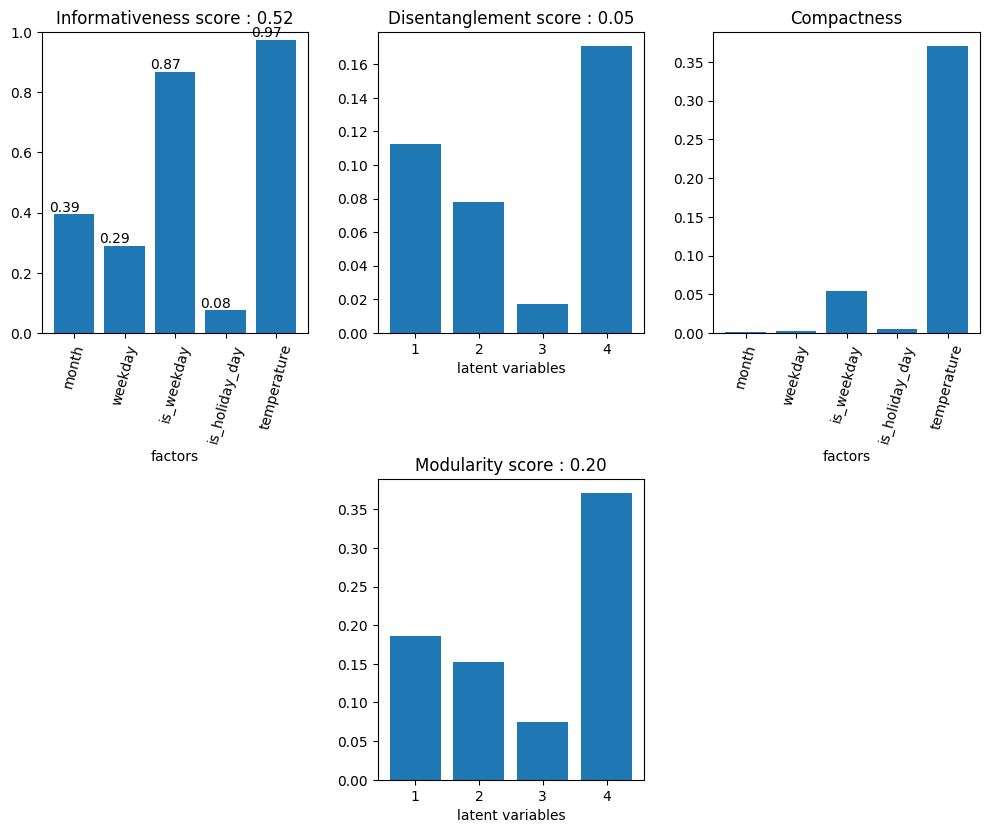

In [36]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [37]:
x_hat = new_cae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

0.8382364026994793

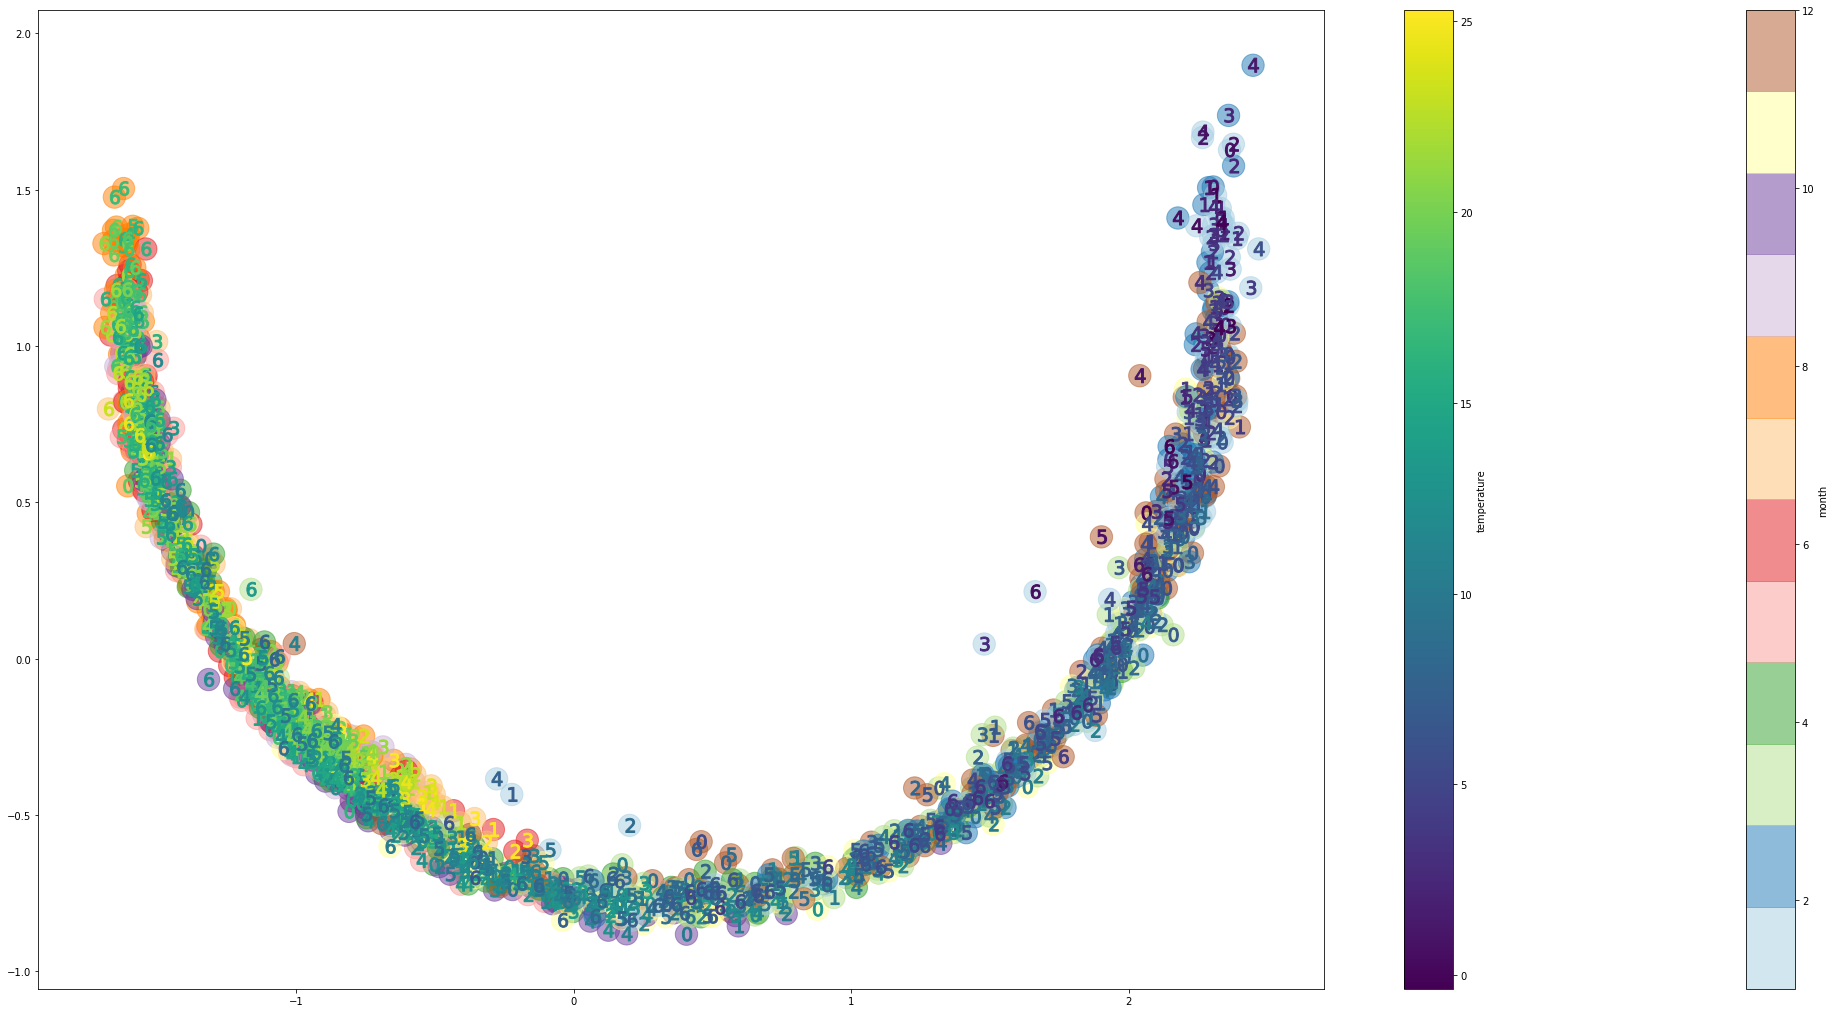

In [38]:
prez_2D(x_encoded)

Mutual Information Gap : 0.03


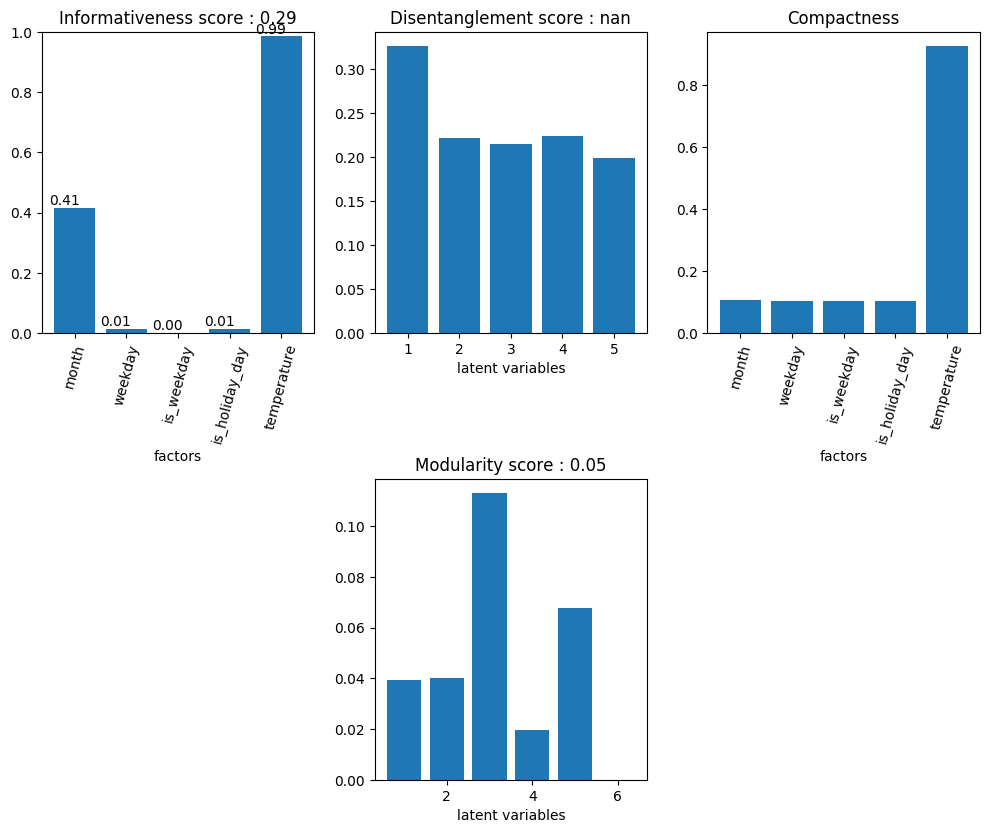

In [41]:
cond_emb = new_cae.cond_embedding.predict(dataset_emb['train']['x'][1:])
model_eval, importanceMatrix =evaluate_latent_code(cond_emb, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, 6, factorDesc)

## Essai de la loss de mutual info

In [25]:
import callbacks
importlib.reload(callbacks)
from callbacks import *

In [26]:
def affinity_matrix(A):
    d0 = A.shape[0]
    d1 = A.shape[1]
    A_tiled1 = np.tile(A.reshape(d0,1,d1), [1,d0,1])
    A_tiled2 = np.tile(A.reshape(1,d0,d1), [d0,1,1])
    gram_A = np.sqrt(np.sum(np.square(A_tiled1 - A_tiled2 ), axis=-1))

    return gram_A

pca_test=PCA(6)
x_pca = pca_test.fit_transform(dataset_emb['train']['x'][0])
y_mat = 1 * (affinity_matrix(x_pca) <=1.5)

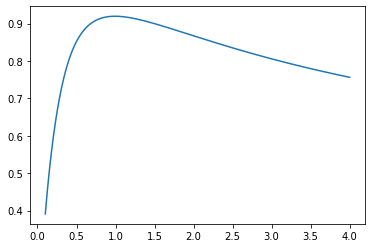

In [29]:
#Trouver le meilleur sigma
sigma = np.linspace(0.1,4, num=300, endpoint=True)

s_test=[]
for s in sigma:
    x_mat = numpy_make_Gram_matrix(dataset_emb['train']['x'][0],s)
    
    s_test.append(np.trace(np.matmul(x_mat,y_mat.T))/(np.linalg.norm(x_mat, "fro")*np.linalg.norm(y_mat, "fro")))
sop=sigma[np.argmax(s_test)]
    
plt.plot(sigma, s_test)

In [27]:
#print(sop)
sop = 0.9869565217391304

In [28]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur

In [29]:
#root git folder 
name_model="cvae_mutualinfo"
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [58]:
cond_to_emb

[12, 48]

In [31]:
len(vae_params.model_params.emb_dims)

0

In [32]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[36,22,10],[12,4],6]
vae_params.model_params.nb_encoder_ensemble = 1


loss_weights = {"recon_loss" : 1, "kl_loss" : 0.3, "info_loss":66}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_loss.options["scale"] = sop
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5

In [33]:
mi_cvae=CVAE(vae_params)
mi_cvae.VAE_params.model_params.cond_insert

['encoder', 'decoder']

In [34]:
mi_cvae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 10230       x_inputs[0][0]                   
                                                                 cond_inputs_0[0][0]           

In [35]:
epochs=500

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [37]:
               
histinfo = InformationHistory(scale=sop,alpha=1.01,dataset_train=dataset_emb['train']['x'],
                              cond_insert = mi_cvae.VAE_params.model_params.cond_insert,
                              period=np.unique(np.logspace(0,4,endpoint=True, num=500, dtype=int)),
                              infotoeval=["XZ", "X(C+Z)", "CZ", "CEmb", "XX'"], printlogger=True)

## START TRAINING ##
Mutual informations for epoch 1 are XZ :  -50.250 ; X(C+Z) :  142.005 ; CZ :  95.161 ; CEmb :  117.234 ; XX' :  54.109
Mutual informations for epoch 2 are XZ :  -51.545 ; X(C+Z) :  142.028 ; CZ :  90.011 ; CEmb :  112.679 ; XX' :  60.433
Mutual informations for epoch 3 are XZ :  -52.116 ; X(C+Z) :  142.063 ; CZ :  87.496 ; CEmb :  110.411 ; XX' :  48.926
Mutual informations for epoch 4 are XZ :  -52.623 ; X(C+Z) :  142.059 ; CZ :  85.223 ; CEmb :  108.329 ; XX' :  56.193
Mutual informations for epoch 5 are XZ :  -52.992 ; X(C+Z) :  142.051 ; CZ :  83.260 ; CEmb :  106.521 ; XX' :  47.331
Mutual informations for epoch 6 are XZ :  -53.305 ; X(C+Z) :  142.075 ; CZ :  81.838 ; CEmb :  105.225 ; XX' :  60.233
Mutual informations for epoch 7 are XZ :  -53.694 ; X(C+Z) :  142.126 ; CZ :  80.357 ; CEmb :  103.769 ; XX' :  42.399
Mutual informations for epoch 8 are XZ :  -54.006 ; X(C+Z) :  142.092 ; CZ :  78.996 ; CEmb :  102.565 ; XX' :  47.481
Mutual informations for epo

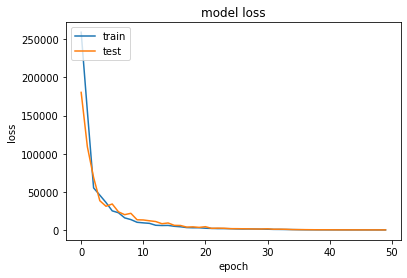

## MODEL SAVED ##


In [38]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 50, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

In [39]:
mi_cvae.maketrainable(modelpart=['encoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['decoder'], boolean=False)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=True)

Change trainable status of encoder layers
Change trainable status of decoder layers
Change trainable status of cond_embedding layers


In [40]:
for lay in mi_cvae.decoder.layers:
    print(lay.trainable)

False
False
False
True
False
False


In [41]:
for i in ['model','encoder', 'decoder', 'cond_embedding']:
    getattr(mi_cvae,i).summary()

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 10230       x_inputs[0][0]                   
                                                                 cond_inputs_0[0][0]           

## START TRAINING ##
Mutual informations for epoch 51 are XZ :  -53.820 ; X(C+Z) :  142.731 ; CZ :  62.930 ; CEmb :  126.658 ; XX' :  -34.918
Mutual informations for epoch 52 are XZ :  -53.788 ; X(C+Z) :  142.747 ; CZ :  62.624 ; CEmb :  126.417 ; XX' :  -42.409
Mutual informations for epoch 53 are XZ :  -53.709 ; X(C+Z) :  142.764 ; CZ :  62.222 ; CEmb :  126.163 ; XX' :  -52.295
Mutual informations for epoch 54 are XZ :  -53.578 ; X(C+Z) :  142.779 ; CZ :  61.805 ; CEmb :  125.902 ; XX' :  -40.246
Mutual informations for epoch 55 are XZ :  -53.378 ; X(C+Z) :  142.797 ; CZ :  61.353 ; CEmb :  125.666 ; XX' :  -44.273
Mutual informations for epoch 56 are XZ :  -53.088 ; X(C+Z) :  142.820 ; CZ :  60.879 ; CEmb :  125.502 ; XX' :  -32.564
Mutual informations for epoch 58 are XZ :  -52.236 ; X(C+Z) :  142.834 ; CZ :  59.875 ; CEmb :  125.402 ; XX' :  -41.271
Mutual informations for epoch 59 are XZ :  -51.778 ; X(C+Z) :  142.783 ; CZ :  59.498 ; CEmb :  125.461 ; XX' :  -43.373
Mutual info

Mutual informations for epoch 182 are XZ :  -5.304 ; X(C+Z) :  144.317 ; CZ :  7.224 ; CEmb :  7.127 ; XX' :  -11.801
Mutual informations for epoch 185 are XZ :  -4.028 ; X(C+Z) :  144.296 ; CZ :  6.658 ; CEmb :  6.714 ; XX' :  -8.740
Mutual informations for epoch 189 are XZ :  -2.675 ; X(C+Z) :  144.257 ; CZ :  5.886 ; CEmb :  6.023 ; XX' :  -11.171
Mutual informations for epoch 192 are XZ :  -2.301 ; X(C+Z) :  144.226 ; CZ :  5.513 ; CEmb :  5.954 ; XX' :  -8.291
Mutual informations for epoch 196 are XZ :  -1.220 ; X(C+Z) :  144.156 ; CZ :  4.884 ; CEmb :  5.590 ; XX' :  -8.124
Mutual informations for epoch 199 are XZ :  -0.338 ; X(C+Z) :  144.045 ; CZ :  4.668 ; CEmb :  5.592 ; XX' :  -7.837
Mutual informations for epoch 203 are XZ :  0.111 ; X(C+Z) :  143.924 ; CZ :  4.254 ; CEmb :  5.388 ; XX' :  -8.596
Mutual informations for epoch 207 are XZ :  0.606 ; X(C+Z) :  143.802 ; CZ :  4.093 ; CEmb :  5.381 ; XX' :  -6.466
Mutual informations for epoch 211 are XZ :  0.737 ; X(C+Z) :  14

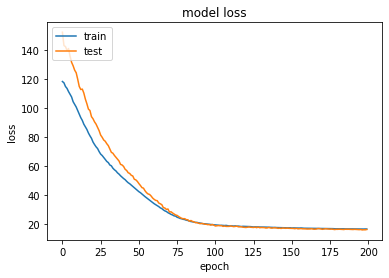

## MODEL SAVED ##


In [42]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 200, verbose=0,
              batch_size=batch_size, callbacks=[histinfo])

In [43]:
cond_emb = mi_cvae.cond_embedding.predict(dataset_emb['train']['x'][1:])

Mutual Information Gap : 0.01


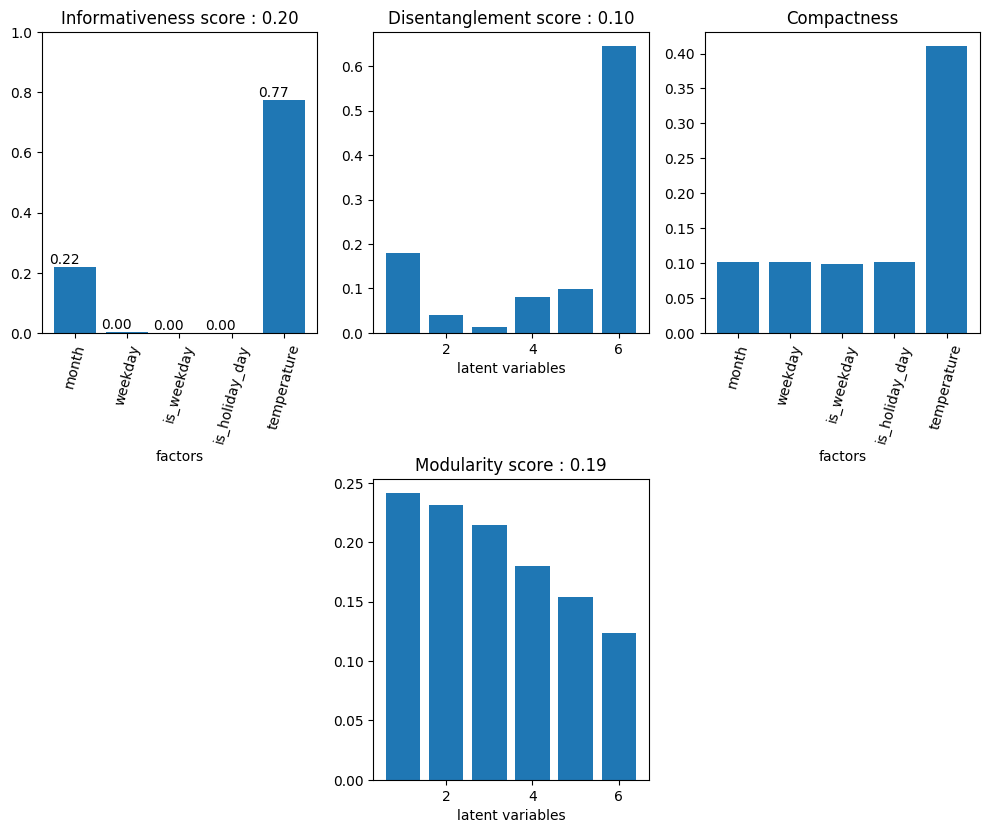

In [44]:
model_eval, importanceMatrix = evaluate_latent_code(cond_emb, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, 6, factorDesc)

In [45]:
mi_cvae.maketrainable(modelpart=['decoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=False)
for lay in mi_cvae.decoder.get_layer("cond_emb").layers:
    print(lay.trainable)
for lay in mi_cvae.encoder.layers:
    print(lay.trainable)

Change trainable status of decoder layers
Change trainable status of cond_embedding layers
False
False
False
False
False
False
False
True
True
True
False
True
True
True


## START TRAINING ##
Mutual informations for epoch 253 are XZ :  2.188 ; X(C+Z) :  143.133 ; CZ :  3.353 ; CEmb :  6.069 ; XX' :  4.194
Mutual informations for epoch 258 are XZ :  2.101 ; X(C+Z) :  143.101 ; CZ :  3.241 ; CEmb :  6.069 ; XX' :  4.773
Mutual informations for epoch 263 are XZ :  2.014 ; X(C+Z) :  143.065 ; CZ :  3.134 ; CEmb :  6.069 ; XX' :  4.178
Mutual informations for epoch 268 are XZ :  1.996 ; X(C+Z) :  143.101 ; CZ :  3.005 ; CEmb :  6.069 ; XX' :  3.381
Mutual informations for epoch 273 are XZ :  1.954 ; X(C+Z) :  143.096 ; CZ :  2.909 ; CEmb :  6.069 ; XX' :  4.335
Mutual informations for epoch 278 are XZ :  1.933 ; X(C+Z) :  143.071 ; CZ :  2.864 ; CEmb :  6.069 ; XX' :  6.005
Mutual informations for epoch 283 are XZ :  1.980 ; X(C+Z) :  143.121 ; CZ :  2.823 ; CEmb :  6.069 ; XX' :  5.324
Mutual informations for epoch 289 are XZ :  2.065 ; X(C+Z) :  143.223 ; CZ :  2.771 ; CEmb :  6.069 ; XX' :  5.672
Mutual informations for epoch 294 are XZ :  2.099 ; X(C+Z) 

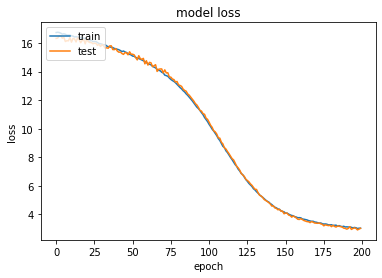

## MODEL SAVED ##


In [46]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 200, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

Mutual Information Gap : 0.11


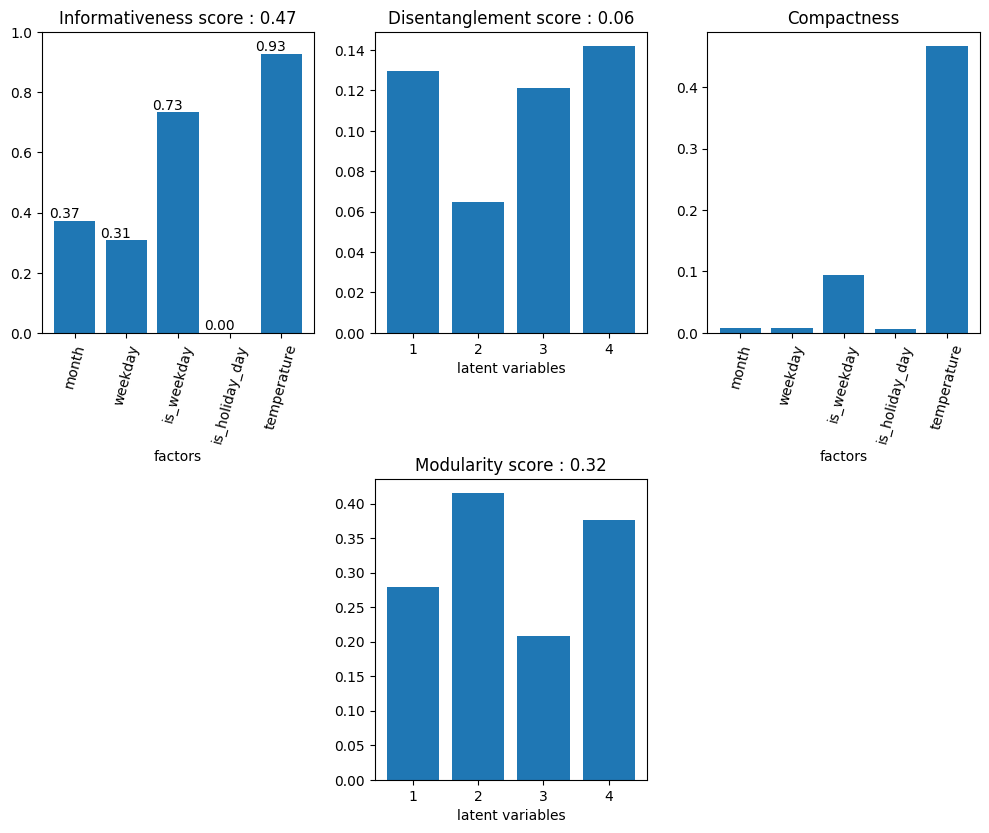

In [47]:
x_encoded = mi_cvae.encoder.predict(dataset_emb['train']['x'])[0]
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [48]:
#mi_cvae.save()
loss_weights = {"recon_loss" : 1, "kl_loss" : 0.67, "info_loss" : 66, "mutualinfo_loss":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None,
                             options={"prior_mu":0., "log_prior_sigma":0., "kl_annealing":0., "alpha":1.01, "scale":sop, "kappa":1.})
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1.]


In [49]:
mi_cvae.load_model(retrieve_model_architecture=True, training_params=vae_params.training_params)

Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003
Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 10230       x_inputs[0][0]                  

In [50]:
mi_cvae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= 2000, verbose=0,
              batch_size=128, callbacks=[earl_stop, histinfo])

## START TRAINING ##


InvalidArgumentError:  Self-adjoint eigen decomposition was not successful. The input might not be valid.
	 [[node loss_6/decoder_loss/SelfAdjointEigV2_3 (defined at /home/goubetcle/Documents/Git/VAE//src/models.py:65) ]] [Op:__inference_keras_scratch_graph_423446]

Function call stack:
keras_scratch_graph


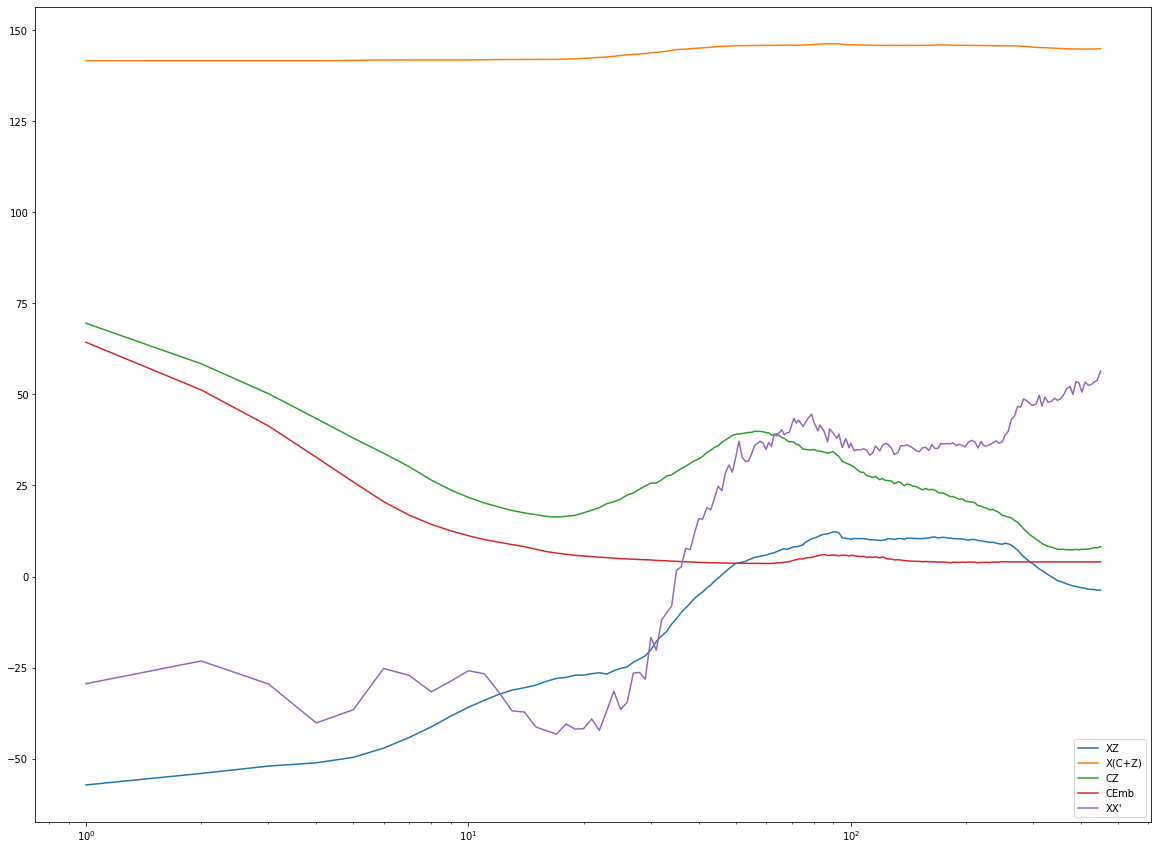

In [99]:
plt.figure(figsize=(20,15))
for key, list_val in histinfo.MI.items():
    plt.plot(histinfo.period[:len(list_val)], list_val, label=key)
plt.xscale("log")
plt.legend()

In [107]:
x_encoded = mi_cvae.encoder.predict(dataset_emb['train']['x'])[0]

Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003
Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 10230       x_inputs[0][0]                  

Mutual Information Gap : 0.04


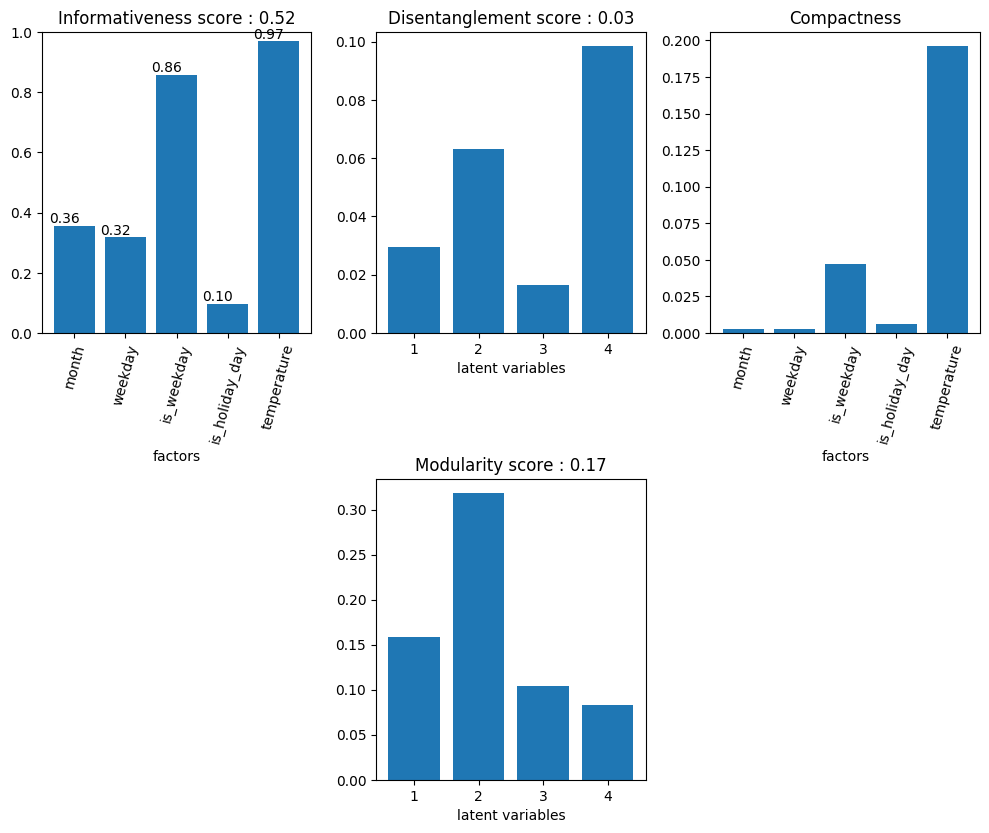

In [108]:
model_eval, importanceMatrix = evaluate_latent_code(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [109]:
x_hat = mi_cvae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

0.8057422566243744